# <center>Sentiment Analysis & Neural Machine Translation</center>
<center>Shan-Hung Wu & DataLab<br/>Fall 2017</center>

Here we want to show how to use **recurrent neural networks** (**rnn**) to model continuous sequence like nature language, and use it on not only article comprehension but also word generation. We will introduce two datasets, [Large Movie Review](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis and [UM-Corpus](http://www.lrec-conf.org/proceedings/lrec2014/pdf/774_Paper.pdf) for machine translation.

# <center>Recurrent Neural Networks</center>

<center><img src='imgs/recurrent_neural_networks.jpg' width='60%' /></center>

There are several RNN related layers already implemented in [tensorflow.contrib.rnn](https://www.tensorflow.org/api_guides/python/contrib.rnn). To construct a **simple rnn**, we should first define the **cell** and apply it into the network. Here is a dummy example:

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import tensorflow as tf
import numpy as np

simple_cell = tf.contrib.rnn.BasicRNNCell(num_units=128)
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=128) # you can also use advanced LSTM or GRU cell
outputs, state = tf.nn.dynamic_rnn(lstm_cell, tf.constant(np.float32(np.random.rand(4, 12, 300))), dtype=tf.float32)

print(outputs)
print(state)

/home/yesray0216/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Tensor("rnn/transpose:0", shape=(4, 12, 128), dtype=float32)
LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(4, 128) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(4, 128) dtype=float32>)


# <center>Sentiment Analysis</center>
We try to do sentiment analysis using RNN for **modeling a movie review** and judege it's **a favorable comment or not**.

In [3]:
import pandas as pd

train_csv = pd.read_csv('dataset/imdb/train.csv')
test_csv = pd.read_csv('dataset/imdb/test.csv')

print(train_csv.head(n=10))

                                              review  sentiment
0  remarkable fact participation klaus kinski pla...          0
1  bought movie dvd watched first time night fan ...          1
2  movie proves judge movie awesome artwork dvd c...          0
3  gave film superbly consistent movie pure abili...          1
4  hm enjoyable movie poke plot holes point atroc...          0
5  watching movie waste time tempted leave middle...          0
6  engrossing drama four men canoing weekend remo...          1
7  bad acting bad writing poorly written film bad...          0
8  innocent man steve guttenberg one night stand ...          0
9  broken bow takes us back began set years futur...          1


To feed a word into RNN one by one, we should **transform words into vectors** first which is [Word2vec](https://en.wikipedia.org/wiki/Word2vec) we have discussed in previous lab. Instead of train ourself, we use an **existing Word2vec** by [spaCy](https://spacy.io/) this time. For those who first use spaCy, you can install it via pip and don't forget to **download English model**.
```
    pip install spacy
    python -m spacy download en
```

In [4]:
import spacy

nlp = spacy.load('en')

word_apple = nlp('apple')
word_banana = nlp('banana')
word_mac = nlp('mac')

print('%s vs %s: %.6f'%(word_apple, word_banana, word_apple.similarity(word_banana)))
print('%s vs %s: %.6f'%(word_apple, word_mac, word_apple.similarity(word_mac)))
print('%s vs %s: %.6f'%(word_banana, word_mac, word_banana.similarity(word_mac)))

apple vs banana: 0.583184
apple vs mac: 0.574916
banana vs mac: 0.243292


Just like [Competition01](https://nthu-datalab.github.io/ml/competitions/01_Response_Selection/01_Response_Selection.html), we should do some text preprocessing.

In [5]:
def remove_unknown_words(csv):
    dat = []
    n = len(csv)
    
    for i in range(n):
        s = csv.loc[i]['review']
        s = ' '.join([w for w in s.split(' ') if w in nlp.vocab])

        dat.append([s, csv.loc[i]['sentiment']])
    
    return dat

train_dat = remove_unknown_words(train_csv)
test_dat = remove_unknown_words(test_csv)

print(train_dat[:3])

[['remarkable fact participation klaus kinski plays priest ask bad bad movie overall', 0], ['bought movie watched first time night fan tolkien work years ever since got high school grow movie perhaps mother kept away definitely children bad graphic sense themes would go right year olds heads overall animation excellent considering made thought story followed book fairly well loose sense bothered add another minutes tack return king parts would made ultimate movie bothered abrupt end heard return king sucked bothered even bad one great animation film might garnered higher vote give hope peter jackson books justice new live action', 1], ['movie proves judge movie awesome artwork cover also goes show learn movie buy get someone christmas beginning movie actually looks somewhat promising well meet characters pumpkin jack old guy street brings college co eds book full witch spells leaves annual haunted house movie takes place drinking fighting soft core porn action movie finally takes place

## Padding and Bucketing

<center><img src='imgs/padding_and_bucketing.png' width='60%' /></center>

For batch training, we should make sure that the **sequences in smae batch have same length**. In nature language processing, we are used to **adding some token** after finished sentence which we means **padding**. But if there are too many paddings token in batch, it may hurt model's performance since **padding will domain whole sentnence** and your model can learn nothing. We introduce a naive solution to this, bucketing. Bucketing is to **re-arrange your sentences** so that each batch has **as similar length as possible**, preventing lots of paddings.

In [6]:
class BatchGenerator:
    def __init__(self, dat, batch_size):
        n = len(dat)
        lst = [i for i in range(n)]
        lst = sorted(lst, key=lambda i: len(dat[i][0].split(' ')))
        
        self.batch_xs, self.batch_ys, self.reviews = [], [], []
        
        for i in range(n//batch_size):
            long = len(dat[lst[(i+1)*batch_size-1]][0].split(' '))
            batch_x = np.zeros((batch_size, long, 300))
            batch_y = np.zeros((batch_size, 2))
            review = []
            
            for j in range(batch_size):
                words = dat[lst[i*batch_size+j]][0].split(' ')
                for k in range(len(words)):
                    batch_x[j][k] = nlp(words[k]).vector # use existing Word2vec model
                for k in range(k, long):
                    batch_x[j][k] = nlp(' ').vector # padding with ' '
                
                batch_y[j][dat[lst[i*batch_size+j]][1]] = 1 # represent class as 1-hot vector
                review.append(dat[lst[i*batch_size+j]][0])
            
            self.batch_xs.append(batch_x)
            self.batch_ys.append(batch_y)
            self.reviews.append(review)
        
    def get(self, batch_id):
        return self.batch_xs[batch_id], self.batch_ys[batch_id], self.reviews[batch_id]

In [7]:
batch = BatchGenerator(train_dat, 32)

xs, ys, rv = batch.get(0)
print(xs[0])
print(ys[0])
print(rv[0])

[[ 0.2071     -0.47656     0.15479    ..., -0.26411    -0.16523001  0.23532   ]
 [-0.50777     0.24716    -0.15457    ...,  0.023132   -0.10737    -0.089831  ]
 [-0.42625001  0.44310001 -0.34516999 ..., -0.4303     -0.068851    0.12875   ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
[ 1.  0.]
movie terrible good effects


## Building RNN Graph

Now we can start to build our RNN model. **Adding clear variable scope** for each component in the graph is a good habbit, and it may help much when cooperating with aother one.

In [8]:
class SentimentReviewRNN:
    def __init__(self):
        with tf.variable_scope('rnn_i/o'):
            # use None for batch size and dynamic sequence length
            self.inputs = tf.placeholder(tf.float32, shape=[None, None, 300])
            self.groundtruths = tf.placeholder(tf.float32, shape=[None, 2])
        
        with tf.variable_scope('rnn_cell'):
            self.cell = tf.contrib.rnn.LSTMCell(128)
            # project RNN output into target class dimension
            self.out_cell = tf.contrib.rnn.OutputProjectionWrapper(self.cell, 2)
        
        with tf.variable_scope('rnn_forward'):
            # use dynamic_rnn for different length
            self.outputs, _ = tf.nn.dynamic_rnn(self.out_cell, self.inputs, dtype=tf.float32) 
            self.outputs = self.outputs[:, -1, :] # only use the last output of sequence
        
        with tf.variable_scope('rnn_loss'):
            # use cross_entropy as class loss
            self.loss = tf.losses.softmax_cross_entropy(onehot_labels=self.groundtruths, logits=self.outputs)
            self.optimizer = tf.train.AdamOptimizer(0.02).minimize(self.loss)
        
        with tf.variable_scope('rnn_accuracy'):
            self.accuracy = tf.contrib.metrics.accuracy(labels=tf.argmax(self.groundtruths, axis=1), 
                                                        predictions=tf.argmax(self.outputs, axis=1))
    
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer()) # don't forget to initial all variables
        self.saver = tf.train.Saver() # a saver is for saving or restoring your trained weight
        
    def train(self, batch_x, batch_y):
        fd = {}
        fd[self.inputs] = batch_x
        fd[self.groundtruths] = batch_y
        # feed in input and groundtruth to get loss and update the weight via Adam optimizer
        loss, accuracy, _ = self.sess.run([self.loss, self.accuracy, self.optimizer], fd)
        
        return loss, accuracy
    
    def test(self, batch_x, batch_y):
        fd = {}
        fd[self.inputs] = batch_x
        fd[self.groundtruths] = batch_y
        prediction, accuracy = self.sess.run([self.outputs, self.accuracy], fd)
            
        return prediction, accuracy
    
    def save(self, e):
        self.saver.save(self.sess, 'model/rnn/rnn_%d.ckpt'%(e+1))
    
    def restore(self, e):
        self.saver.restore(self.sess, 'model/rnn/rnn_%d.ckpt'%(e))

In [9]:
# hyperparameter of our network
EPOCHS = 15
BATCH_SIZE = 128

In [10]:
train_batch = BatchGenerator(train_dat, BATCH_SIZE)
test_batch = BatchGenerator(test_dat, BATCH_SIZE)

n_train = len(train_dat)//BATCH_SIZE
n_test = len(test_dat)//BATCH_SIZE

In [11]:
tf.reset_default_graph()
model = SentimentReviewRNN()

## Training & Testing

After preparing batch and model, we can train it and see how the performance is. 

In [12]:
rec_loss = []

for e in range(EPOCHS): # train for several epochs
    loss_train = 0
    accuracy_train = 0
    
    for b in range(n_train): # feed batches one by one
        batch_x, batch_y, _ = train_batch.get(b)
        loss_batch, accuracy_batch = model.train(batch_x, batch_y)
        
        loss_train += loss_batch
        accuracy_train += accuracy_batch
    
    loss_train /= n_train
    accuracy_train /= n_train
    
    model.save(e) # save your model after each epoch
    rec_loss.append([loss_train, accuracy_train])

np.save('./model/rnn/rec_loss.npy', rec_loss)

The loss curve and accuracy curve are both pretty good!

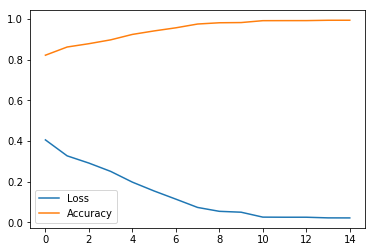

In [13]:
rec_loss = np.load('./model/rnn/rec_loss.npy')

import matplotlib.pyplot as plt

plt_loss = plt.plot([rec_loss[i][0] for i in range(len(rec_loss))])
plt_accuracy = plt.plot([rec_loss[i][1] for i in range(len(rec_loss))])
plt.legend(['Loss', 'Accuracy'])
plt.show()

For testing, we can **just restore** trained weight.

In [14]:
model.restore(EPOCHS)

INFO:tensorflow:Restoring parameters from model/rnn/rnn_15.ckpt


In [15]:
accuracy_test = 0

for b in range(n_test):
    batch_x, batch_y, _ = test_batch.get(b)
    _, accuracy_batch = model.test(batch_x, batch_y)
        
    accuracy_test += accuracy_batch
    
accuracy_test /= n_test

print('Test: %.4f'%(accuracy_test))

Test: 0.8456


In [16]:
%reset -sf

# <center>Sequence-to-Sequence</center>

<img src='imgs/seq2seq.png' width='60%' />

**Sequence-to-Sequence (Seq2Seq)** models have enjoyed great success in a variety of tasks such as machine translation, speech recognition, and text summarization. Seq2Seq is constructed of two RNNs, **encoder and decoder**. Encoder encodes input sequence into a hidden vector first, and decoder will gererate words one by one based on it. 

# <center>Neural Machine Translation</center>

**Neural Machine Translation (NMT)** is one of NLP tasks, which uses deep learning to solve language translation. Here we use [UM-Corpus](http://www.lrec-conf.org/proceedings/lrec2014/pdf/774_Paper.pdf) and typical Seq2Seq with **attention mechanism** to build our NMT model.

In [17]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

Take a look at dataset (TA has preprocessed first).

In [18]:
import numpy as np

en_corpus = np.load('./dataset/translate/enCorpus.npy')
en_vocab = np.load('./dataset/translate/enVocab.npy').tolist() # use tolist() to transform back to dict()
en_rev = np.load('./dataset/translate/enRev.npy').tolist()

ch_corpus = np.load('./dataset/translate/chCorpus.npy')
ch_vocab = np.load('./dataset/translate/chVocab.npy').tolist()
ch_rev = np.load('./dataset/translate/chRev.npy').tolist()

for i in range(4):
    print(' '.join([en_rev[en_corpus[i][j]]  for j in range(len(en_corpus[i]))]))
    print(' '.join([ch_rev[ch_corpus[i][j]]  for j in range(len(ch_corpus[i]))]))
    print('')

<BEG> all that remains for me to do is to say <UNK> <END>
<BEG> 我 剩下 要 做 的 事 就是 <UNK> 了 <END>

<BEG> all the <UNK> members young and old went out to <UNK> the crops <END>
<BEG> 全体 <UNK> <UNK> 都 <UNK> <UNK> 去 了 <END>

<BEG> as soon as they finish the new <UNK> administration building our offices are going to be moved <END>
<BEG> 他们 一 <UNK> 商业 管理 大楼 我们 的 办公室 就 <UNK> <END>

<BEG> beautiful though the <UNK> was we thought it was <UNK> so we didnt buy it <END>
<BEG> 不管 <UNK> 如何 漂亮 我们 认为 <UNK> <UNK> 还是 没有 买 它 <END>



For the presentation issue, we only preserve sentences without 'UNK' token.

In [19]:
en_corpus_clean = []
ch_corpus_clean = []

for i in range(len(en_corpus)):
    if not(en_vocab['<UNK>'] in en_corpus[i] or ch_vocab['<UNK>'] in ch_corpus[i]): # remove '<UNK>' sentence
        en_corpus_clean.append(en_corpus[i])
        ch_corpus_clean.append(ch_corpus[i])

for i in range(4):
    print(' '.join([en_rev[en_corpus_clean[i][j]]  for j in range(len(en_corpus_clean[i]))]))
    print(' '.join([ch_rev[ch_corpus_clean[i][j]]  for j in range(len(ch_corpus_clean[i]))]))
    print('')

<BEG> its my father who came here to look for me this morning <END>
<BEG> 上午 来 找 我 的 是 我 父亲 <END>

<BEG> no doubt you would like to know how i have been getting along since i left school <END>
<BEG> 毫无疑问 你 肯定 想 知道 我 离开 学校 以来 的 情况 <END>

<BEG> she as well as the other students has learned this method <END>
<BEG> 她 和 其他 学生 一样 也 学会 了 这种 方法 <END>

<BEG> like other candidates i have the ability to do this job <END>
<BEG> 和 其他人 一样 我 有 能力 完成 这份 工作 <END>



## Prepare Translation Batch

In this lab, we use [legacy_seq2seq](https://www.tensorflow.org/api_docs/python/tf/contrib/legacy_seq2seq/embedding_attention_seq2seq) which provides a fasy way to build up seq2seq model with attention. Be careful that legacy_seq2seq is **time major** which means the **input and output should be a list** contains word batch.

<img src='imgs/machine_translation.png' width='60%' />
<img src='imgs/time_major.png' width='60%' />

In [20]:
en_max_len = 0
ch_max_len = 0

for i in range(len(en_corpus_clean)): # caculate max length
    en_max_len = max(en_max_len, len(en_corpus_clean[i]))
    ch_max_len = max(ch_max_len, len(ch_corpus_clean[i]))

print(en_max_len, ch_max_len)

32 32


In [21]:
class BatchGenerator:
    def __init__(self, en_corpus, ch_corpus, en_pad, ch_pad, en_max_len, ch_max_len, batch_size):
        n = len(en_corpus)
        batch_num = len(en_corpus)//batch_size
        n = batch_num*batch_size
        
        self.xs = [np.zeros(n, dtype=np.int32) for _ in range(en_max_len)] # encoder inputs
        self.ys = [np.zeros(n, dtype=np.int32) for _ in range(ch_max_len)] # decoder inputs
        self.gs = [np.zeros(n, dtype=np.int32) for _ in range(ch_max_len)] # decoder outputs
        self.ws = [np.zeros(n, dtype=np.float32) for _ in range(ch_max_len)] # decoder weight for loss caculation
        
        self.en_max_len = en_max_len
        self.ch_max_len = ch_max_len
        self.batch_size = batch_size
        
        for b in range(batch_num):
            for i in range(b*batch_size, (b+1)*batch_size):
                for j in range(len(en_corpus[i])-2):
                    self.xs[j][i] = en_corpus[i][j+1]
                for j in range(j+1, en_max_len):
                    self.xs[j][i] = en_pad
                
                for j in range(len(ch_corpus[i])-1):
                    self.ys[j][i] = ch_corpus[i][j]
                    self.gs[j][i] = ch_corpus[i][j+1]
                    self.ws[j][i] = 1.0
                for j in range(j+1, ch_max_len): # don't forget padding and let loss weight zero
                    self.ys[j][i] = ch_pad
                    self.gs[j][i] = ch_pad
                    self.ws[j][i] = 0.0
    
    def get(self, batch_id):
        x = [self.xs[i][batch_id*self.batch_size:(batch_id+1)*self.batch_size] for i in range(self.en_max_len)]
        y = [self.ys[i][batch_id*self.batch_size:(batch_id+1)*self.batch_size] for i in range(self.ch_max_len)]
        g = [self.gs[i][batch_id*self.batch_size:(batch_id+1)*self.batch_size] for i in range(self.ch_max_len)]
        w = [self.ws[i][batch_id*self.batch_size:(batch_id+1)*self.batch_size] for i in range(self.ch_max_len)]
        
        return x, y, g, w

batch = BatchGenerator(en_corpus_clean, ch_corpus_clean, 
                       en_vocab['<PAD>'], ch_vocab['<PAD>'], en_max_len, ch_max_len, 4)

x, y, g, w = batch.get(2)
for i in range(4):
    print(' '.join([en_rev[x[j][i]] for j in range(en_max_len)]))
    print(' '.join([ch_rev[y[j][i]] for j in range(ch_max_len)]))
    print(' '.join([ch_rev[g[j][i]] for j in range(ch_max_len)]))
    print('')

have you applied any of the above strategies in your business <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
<BEG> 你 有没有 把 上面 的 任何 策略 用 在 你 自己 的 生意 上 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
你 有没有 把 上面 的 任何 策略 用 在 你 自己 的 生意 上 <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

if you answered yes to one or more of the above then you need to think about how you handle the matter of time in your application <PAD> <PAD> <PAD> <PAD> <PAD>
<BEG> 如果 您 对 上述 一个 或 一个 以上 的 问题 的 回答 是 肯定 的 那么 就 需要 考虑 如何 在 应用程序 中 处理 时间 问题 <PAD> <PAD> <PAD> <PAD> <PAD>
如果 您 对 上述 一个 或 一个 以上 的 问题 的 回答 是 肯定 的 那么 就 需要 考虑 如何 在 应用程序 中 处理 时间 问题 <END> <PAD> <PAD> <PAD> <PAD> <PAD>

so what should we do to promote peace in addition to the proposals mentioned above <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

## Build Seq2Seq Graph

<img src='imgs/attention.jpg' width='60%' />

For training Seq2Seq, we usually use a trick named **teacher forcing** which can help train more efficiently. But when testing, there isn't teacher any more. In tensorflow implementation, we need to **build 2 same models** with one feeding previous. Since they both **share same weight**, don't forget **reuse RNN cell and model in variable scope**. **Attention mechanim** let decoder **focus on specific input** when decding, and generate more accurate output. Thanks to legacy_seq2seq, attention has been implemented also.

In [22]:
import tensorflow as tf

In [23]:
class MachineTranslationSeq2Seq:
    def __init__(self, en_max_len, ch_max_len, en_size, ch_size):
        self.en_max_len = en_max_len
        self.ch_max_len = ch_max_len
        
        with tf.variable_scope('seq2seq_intput/output'):
            self.enc_inputs = [tf.placeholder(tf.int32, [None]) for i in range(en_max_len)] # time mojor feed
            self.dec_inputs = [tf.placeholder(tf.int32, [None]) for i in range(ch_max_len)]
            self.groundtruths = [tf.placeholder(tf.int32, [None]) for i in range(ch_max_len)]
            self.weights = [tf.placeholder(tf.float32, [None]) for i in range(ch_max_len)]
            
        with tf.variable_scope('seq2seq_rnn'): # training by teacher forcing
            self.out_cell = tf.contrib.rnn.LSTMCell(512)
            self.outputs, _ = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(self.enc_inputs, self.dec_inputs, 
                                                                                    self.out_cell, 
                                                                                    en_size, ch_size, 300)
        with tf.variable_scope('seq2seq_rnn', reuse=True): # predict by feeding previous
            self.pred_cell = tf.contrib.rnn.LSTMCell(512, reuse=True) # reuse cell for train and test
            self.predictions, _ = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(self.enc_inputs, self.dec_inputs, 
                                                                                        self.pred_cell, 
                                                                                        en_size, ch_size, 300, 
                                                                                        feed_previous=True)
        
        with tf.variable_scope('loss'):
            # caculate weighted loss
            self.loss = tf.reduce_mean(tf.contrib.legacy_seq2seq.sequence_loss_by_example(self.outputs, 
                                                                                          self.groundtruths, 
                                                                                          self.weights))
            self.optimizer = tf.train.AdamOptimizer(0.002).minimize(self.loss)
        
        self.sess = tf.Session()
        self.saver = tf.train.Saver()
        self.sess.run(tf.global_variables_initializer())
    
    def train(self, x, y, g, w):
        fd = {}
        for i in range(self.en_max_len):
            fd[self.enc_inputs[i]] = x[i] # show how to feed a list
        
        for i in range(self.ch_max_len):
            fd[self.dec_inputs[i]] = y[i]
            fd[self.groundtruths[i]] = g[i]
            fd[self.weights[i]] = w[i]
        
        loss, _ = self.sess.run([self.loss, self.optimizer], fd)
        
        return loss

    def output(self, x, y):
        fd = {}
        for i in range(self.en_max_len):
            fd[self.enc_inputs[i]] = x[i]
        
        for i in range(self.ch_max_len):
            fd[self.dec_inputs[i]] = y[i]
        
        out = self.sess.run(self.outputs, fd)
        
        return out
    
    def predict(self, x, ch_beg):
        fd = {}
        for i in range(self.en_max_len):
            fd[self.enc_inputs[i]] = x[i]
        
        for i in range(self.ch_max_len): # when feed previous, the fist token should be '<BEG>', and others are useless
            if i==0:
                fd[self.dec_inputs[i]] = np.ones(y[i].shape, dtype=np.int32)*ch_beg
            else:
                fd[self.dec_inputs[i]] = np.zeros(y[i].shape, dtype=np.int32)
        
        pd = self.sess.run(self.predictions, fd)
        
        return pd
    
    def save(self, e):
        self.saver.save(self.sess, 'model/seq2seq/seq2seq_%d.ckpt'%(e+1))
    
    def restore(self, e):
        self.saver.restore(self.sess, 'model/seq2seq/seq2seq_%d.ckpt'%(e))

In [24]:
tf.reset_default_graph()
model = MachineTranslationSeq2Seq(en_max_len, ch_max_len, len(en_vocab), len(ch_vocab))

In [25]:
EPOCHS = 40
BATCH_SIZE = 256
batch_num = len(en_corpus_clean)//BATCH_SIZE

batch = BatchGenerator(en_corpus_clean, ch_corpus_clean, 
                       en_vocab['<PAD>'], ch_vocab['<PAD>'], 
                       en_max_len, ch_max_len, BATCH_SIZE)

In [26]:
rec_loss = []
for e in range(EPOCHS):
    train_loss = 0
    
    for b in range(batch_num):
        x, y, g, w = batch.get(b)
        batch_loss = model.train(x, y, g, w)
        train_loss += batch_loss
    
    train_loss /= batch_num
    rec_loss.append(train_loss)
    model.save(e)
    
np.save('./model/seq2seq/rec_loss.npy', rec_loss)

The loss curve is also good this time.

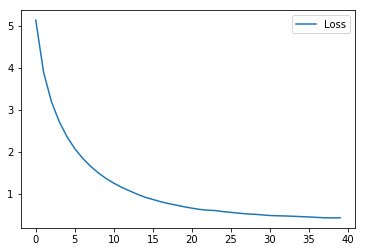

In [27]:
rec_loss = np.load('./model/seq2seq/rec_loss.npy')

import matplotlib.pyplot as plt

plt_loss = plt.plot([rec_loss[i] for i in range(len(rec_loss))])
plt.legend(['Loss'])
plt.show()

In [28]:
model.restore(EPOCHS)

INFO:tensorflow:Restoring parameters from model/seq2seq/seq2seq_40.ckpt


## Cherry Pick and Show Result

<img src='imgs/bleu.png' width='60%' />

[BLEU](https://en.wikipedia.org/wiki/BLEU) is a metric for supervised text generation which finds the **similarity between two sentence based on n-gram token**. Now, we want to show some great translation result which is called **cherry pick**.

In [29]:
import nltk

def cherry_pick(records, n, upper_bound=1.0):
    bleus = []
    
    for en, ch_gr, ch_pd in records:
        bleu = nltk.translate.bleu_score.sentence_bleu([ch_gr], ch_pd) # caculate BLEU by nltk
        bleus.append(bleu)
    
    lst = [i for i in range(len(records)) if bleus[i]<=upper_bound]
    lst = sorted(lst, key=lambda i: bleus[i], reverse=True) # sort by BLEU score
    
    return [records[lst[i]] for i in range(n)]

In [30]:
import random as rd

records = []

for i in range(10):
    i = rd.randint(0, batch_num-1) # random pick one to translate
    
    x, y, g, w = batch.get(i)
    out = model.output(x, y)
    pd = model.predict(x, ch_vocab['<BEG>'])

    for j in range(10):
        j = rd.randint(0, BATCH_SIZE-1)
        
        en = [en_rev[x[i][j]] for i in range(en_max_len)]
        en = en[:en.index('<PAD>')]
        ch_gr = [ch_rev[g[i][j]] for i in range(ch_max_len)]
        if '<END>' in ch_gr:
            ch_gr = ch_gr[:ch_gr.index('<END>')]
        ch_pd = [ch_rev[np.argmax(pd[i][j, :])] for i in range(ch_max_len)]
        if '<END>' in ch_pd:
            ch_pd = ch_pd[:ch_pd.index('<END>')]
        
        records.append([en, ch_gr, ch_pd])

n = 12 # how many result we show
rec_cherry = cherry_pick(records, n)

for i in range(n):
    for j in range(3):
        print(' '.join(rec_cherry[i][j]))
    
    print('')

do you see that i am your friend
你 把 我 当作 你 的 朋友 吗
你 把 我 当作 你 的 朋友 吗

are you saying its from the future
你 是 说 它 来自 未来
你 是 说 它 来自 未来

did i ever turn you down or anything
我 有 拒绝 过 你 吗
我 有 拒绝 过 你 吗

have you heard all that i have said
你 听见 我 刚才 说 的 了 吗
你 听见 我 刚才 说 的 了 吗

i need to know where to reach you
亲爱 的   我要 知道 在 哪里 可以 找到 你
亲爱 的   我要 知道 在 哪里 可以 找到 你

we have to take her to the hospital
快点 送 她 去 医院 啦
快点 送 她 去 医院 啦

except you and your little chocolate drop picked the wrong time to move and the wrong place
选择 了 错误 的 时间 来到 了 错误 的 地点
选择 了 错误 的 时间 来到 了 错误 的 地点

hope they knew what they were doing
是 啊   真 希望 他们 知道 自己 在 做些 什么
是 啊   真 希望 他们 知道 自己 在 做些 什么

hey so if its no big deal
如果 没有 关系 的话
如果 没有 关系 的话

iil call you when its dinner time
习惯 就 好   吃饭 的 时候 我 叫 你们
习惯 就 好   吃饭 的 时候 我 叫 你们

well then i think we can manage that
我 想 我们 可以
我 想 我们 可以

now i know it can be pretty useful
现在 才 知道 这么 有用
现在 才 知道 这么 有用



/home/yesray0216/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/yesray0216/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/yesray0216/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [31]:
%reset -sf

## Assignment

In this assignment, you have to train a **ChatBot** using Seq2Seq model and [Cornell Movie-Dialogs](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). All you have to do includes **text preprocessing**, **batch preparation**, **model training**, and **cherry pick**. You can download all dataset and trained model in this lab [here]().

### Notification:
+ Submit on iLMS your code file (ex: Lab14-103062110.ipynb)
+ Give a **brief report** for every parts you have done
+ The deadline will be **2017/12/07 23:59**